In [1]:
import os
from scripts.paper_figures.input import Input

import basty.project.experiment_processing as experiment_processing
from scripts.paper_figures.process_results import BehaviorData

from basty.utils import misc

In [10]:
RESULTS_FOLDER = r"Z:\mfk\basty-projects\backup-allnohaltere\results\semisupervised_pair_kNN\predictions.15NN.neighbor_weights-distance.neighbor_weights_norm-log_count.activation-standard.voting-soft.voting_weights-None\exports"

BODY_PART_SETS = {"HaltereSwitch": "prob", "Feeding": "prob"}

CONFIG_PATH = r"Z:\mfk\basty-projects\main_cfg.yaml"

PROJECT_PATH = os.path.dirname(CONFIG_PATH)

TMP_RESULT_FOLDER = os.path.join(PROJECT_PATH,'tmp_results')

project = experiment_processing.Project(CONFIG_PATH)

BEHAVIORS = ['Grooming']

BODY_PART_SETS = {"ProboscisPumping": "prob", "Feeding": "prob", "HaltereSwitch": "halt",'Grooming':'thor_post'}

In [3]:
io_process = Input(project, RESULTS_FOLDER, TMP_RESULT_FOLDER)

In [4]:
expt_info_df = io_process.load_expt_info()
df_data = io_process.load_predictions()

In [5]:
# Drop Noise, Feeding, Grooming, ProboscisPumping from df_data
df_data.drop(['Noise','HaltereSwitch'], axis=1, inplace=True)

io_process.create_binary_masks_subfolders(BEHAVIORS)

In [6]:
# Remove all the rows that are 'Fly05252022_SD_5d' in ExptNames
df_data = df_data[~df_data['ExptNames'].str.contains('Fly05252022_SD_5d')]

# Reset index
df_data.reset_index(drop=True, inplace=True)


In [7]:
llh = misc.get_likelihood(project.data_path_dict, CONFIG_PATH)
llh = llh[llh["ExptNames"].isin(df_data.ExptNames.unique())]

Loading existing llh_df.pickle file...


In [8]:
from importlib import reload
import scripts.paper_figures.process_results
reload(scripts.paper_figures.process_results)
from scripts.paper_figures.process_results import BehaviorData

process_data = BehaviorData(df_data, behaviors='Grooming', binary_mask_threshold=0.8,body_parts=BODY_PART_SETS['Grooming'])
process_data.process_expt_names_parallel(llh,io_process.get_binary_mask_subfolder(behavior='Grooming'))

Calculating for Fly05182022_5d...Calculating for Fly05202022_5d...

Calculating for Fly05272022_SD_5d...
Calculating for Fly06072022_5d...
Calculating for Fly05222022_5d...
Calculating for Fly06082022_5d...Calculating for Fly06142022_SD_5d...
Calculating for Fly06152022_6d...

Calculating for Fly06182022_4d...
Calculating for Fly06202022_5d...
Calculating for Fly06212022_5d...
Calculating for Fly06232022_4d_B...
Calculating for Fly06232022_5d_A_SD...
Calculating for Fly06232022_5d_B_SD...
Calculating for Fly06242022_5d_SD_B...
Calculating for Fly06242022_5_SD_A...
Calculating for Fly06252022_5d_SD_A...
Calculating for Fly06252022_5d_SD_B...
Calculating for Fly06262022_5d_SD_A...
Calculating for Fly06272022_5d_A...
Calculating for Fly06272022_5d_SD_A...
Calculating for Fly06282022_5d_B...
Calculating for Fly06282022_5d_SD_B...
Calculating for Fly06292022_5d_A...
Calculating for Fly06292022_5d_B...
Calculating for Fly06302022_5d_A...
Calculating for Fly06302022_5d_B...
Calculating for Fl

In [12]:
masks_based_on_llh = io_process.load_binary_mask('Grooming')
beh_masks = process_data.create_binary_mask_from_behaviors(BEHAVIORS,'Grooming')
masked_data = process_data.update_dictionary_with_final_masked(masks_based_on_llh,beh_masks)

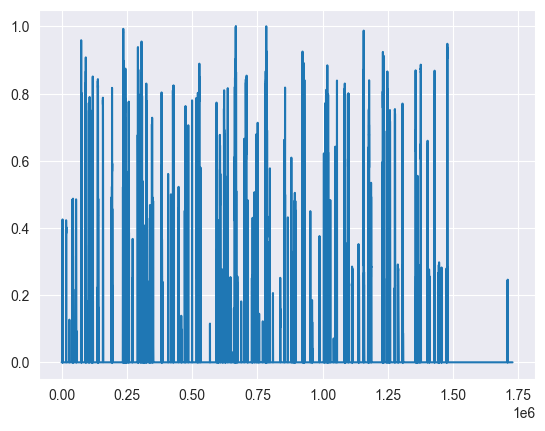

In [20]:
import matplotlib.pyplot as plt
plt.plot(masked_data['Fly05182022_5d']['Fly05182022_5d_final_masked'])

In [29]:
# Remove all the Feeding events that scored less than 0.5

# Masked data is a dictionary, so for each key, we have a dataframe get the column name that ends with _final_masked

for key in masked_data.keys():
    # Get the DataFrame associated with the current key
    df = masked_data[key]
    
    # Filter the column(s) of interest
    column_filtered = df.filter(regex='_final_masked$').columns[0]
    
    # Apply the transformation to the filtered column
    df[column_filtered] = df[column_filtered].apply(lambda x: x if x > 0.8 else 0)
    
    # Update the modified DataFrame back into the dictionary
    masked_data[key] = df


In [30]:
from importlib import reload
import scripts.paper_figures.process_results
reload(scripts.paper_figures.process_results)
from scripts.paper_figures.process_results import BehaviorData

bouts_dict = BehaviorData.find_consecutive_bouts_and_snap_fts(masked_data, io_process, 'Grooming', 60, 0, 60, True)

Processing Experiments: 100%|██████████| 60/60 [01:14<00:00,  1.25s/it] 


In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Plot haltere switch events
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

# Possible values for sd and sex
sd_values = [False, True]
sex_values = ['M', 'F']

grouped_dict = {}

# Initialize an empty dictionary for each group
for sd_value in sd_values:
    for sex_value in sex_values:
        grouped_name = f'SD_{sd_value}_Sex_{sex_value}'
        grouped_dict[grouped_name] = {}

# Loop over each key in final_dataframe to segregate it into one of the 4 groups
for key in bouts_dict.keys():
    sd = name_to_sd.get(key)
    sex = name_to_sex.get(key)
    
    grouped_name = f'SD_{sd}_Sex_{sex}'
    grouped_dict[grouped_name][key] = bouts_dict[key]

In [59]:
import numpy as np
def plot_data(group_dict, color='#d62728',sd=False,sex='F',behavior='Haltere_Switch',fig_path = r'C:\Users\Grover\Documents\GitHub\deepsleepfigs\Fig_4_5'):
    target_dict_name = f'SD_{sd}_Sex_{sex}'
    data_dict = group_dict[target_dict_name]
    
    fig, ax = plt.subplots(figsize=(15, len(data_dict) / 4))
    unique_names = list(data_dict.keys())

    for idx, name in enumerate(unique_names):
        subset_df = data_dict[name]
        subset_df['start_index_hr'] = subset_df['start_index'] / (30*60*60)
        subset_df['stop_index_hr'] = subset_df['stop_index'] / (30*60*60)
        
        for _, row in subset_df.iterrows():
            start_pos = row['start_index_hr']
            width = row['stop_index_hr'] - start_pos
            ax.barh(idx, width, left=start_pos, color=color, edgecolor='none')
            
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(unique_names)
    # Set xticks to be in hours
    if sd:
        ax.set_xticks(np.arange(0, 7, 1))
        ax.set_xticklabels( [tick % 24 for tick in np.arange(0, 7,1)])
    else:
        ax.set_xticks(np.arange(0, 17,2))
        ax.set_xticklabels( [tick % 24 for tick in np.arange(10, 27,2)])
    
    # Add a title
    plt.title(target_dict_name)
    plt.xlim(0,6)
    
    plt.tight_layout()
    # Save the figure to disk
    plt.savefig(os.path.join(fig_path,f'{target_dict_name}_{behavior}.pdf'))
    
    plt.show()
    

[2023-10-29 09:39:54] INFO - maxp pruned
[2023-10-29 09:39:54] INFO - LTSH dropped
[2023-10-29 09:39:54] INFO - cmap pruned
[2023-10-29 09:39:54] INFO - kern dropped
[2023-10-29 09:39:54] INFO - post pruned
[2023-10-29 09:39:54] INFO - PCLT dropped
[2023-10-29 09:39:54] INFO - JSTF dropped
[2023-10-29 09:39:54] INFO - meta dropped
[2023-10-29 09:39:54] INFO - DSIG dropped
[2023-10-29 09:39:54] INFO - GPOS pruned
[2023-10-29 09:39:54] INFO - GSUB pruned
[2023-10-29 09:39:54] INFO - glyf pruned
[2023-10-29 09:39:54] INFO - Added gid0 to subset
[2023-10-29 09:39:54] INFO - Added first four glyphs to subset
[2023-10-29 09:39:54] INFO - Closing glyph list over 'GSUB': 28 glyphs before
[2023-10-29 09:39:54] INFO - Glyph names: ['.notdef', 'A', 'B', 'D', 'F', 'M', 'S', 'a', 'd', 'e', 'eight', 'five', 'four', 'glyph00001', 'glyph00002', 'l', 'nine', 'one', 's', 'seven', 'six', 'space', 'three', 'two', 'underscore', 'x', 'y', 'zero']
[2023-10-29 09:39:54] INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20

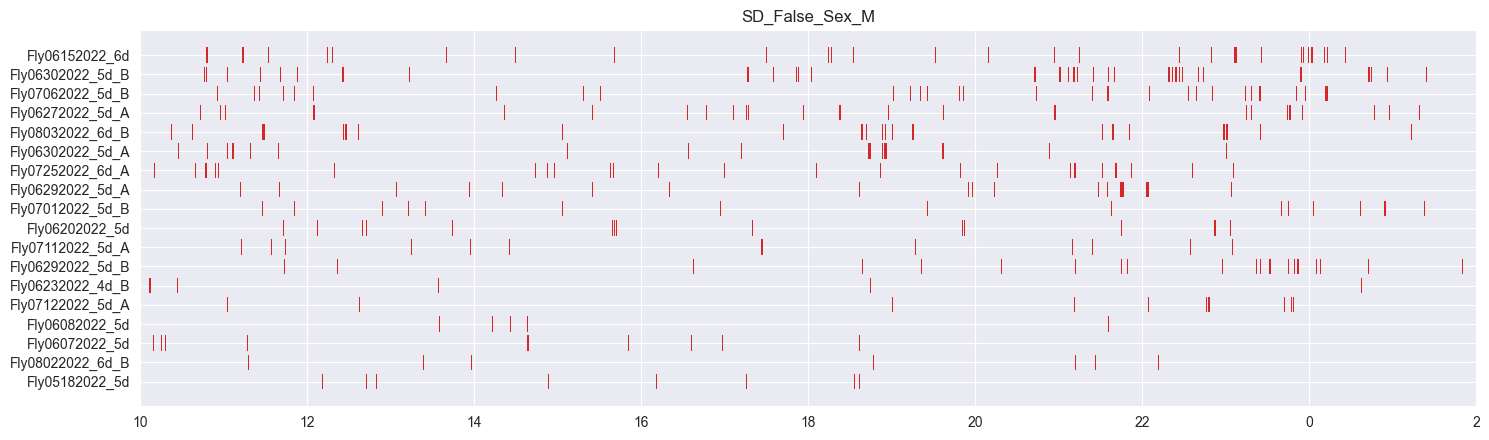

In [61]:
plot_data(grouped_dict,sd=True,sex='M',behavior='Grooming')

In [40]:
import pandas as pd
import numpy as np
# Initialize an empty dictionary to store the final results
grouped_binned = {}

# Process each key-value pair in the grouped_dict
for key, value_dict in grouped_dict.items():
    tmp_results = []
    
    for name, df in value_dict.items():
        df = df.copy()  # Make a copy of the dataframe to avoid modifying the original
        df['ExptNames'] = name
        tmp_results.append(df)

    # Concatenate the dataframes in the result_list
    binned_df = pd.concat(tmp_results, ignore_index=True)
    
    # Add a 'bin' column to the concatenated_df using the 'start_index' column
    binned_df['bin'] = pd.cut(binned_df['start_index'], bins=np.arange(0, 17*60*60*30, 30*60*60*1))
    
    # Store the resulting dataframe in the grouped_binned dictionary
    grouped_binned[key] = binned_df

In [41]:

import numpy as np
# Initialize an empty dictionary called grouped_binned_duration
grouped_binned_duration = {}

# Process each key-value pair in the grouped_dict
for key, df in grouped_binned.items():
    
    # Calculate duration for each row
    df['duration'] = df['stop_index'] - df['start_index']

    # Concatenate the dataframes in the result_list
    total_time_per_bin_per_experiment = df.groupby(['ExptNames', 'bin'])['duration'].sum().reset_index()
    
    total_time_per_bin_per_experiment['duration_sec'] = total_time_per_bin_per_experiment['duration'] / 30
    
    # Store the resulting dataframe in the grouped_binned dictionary
    grouped_binned_duration[key] = total_time_per_bin_per_experiment


In [42]:
import numpy as np
import os
import matplotlib.pyplot as plt

def plot_binned_data(group_dict, sd=False,sex='F',behavior='Haltere_Switch',ylim_val = None,fig_path = r'C:\Users\Grover\Documents\GitHub\deepsleepfigs\Fig_4_5'):
    target_dict_name = f'SD_{sd}_Sex_{sex}'
    data_df = group_dict[target_dict_name]
    
    count_per_bin_per_experiment = data_df.groupby(['ExptNames', 'bin']).size().reset_index(name='Count')
    
    import seaborn as sns
    # Plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=count_per_bin_per_experiment, x='bin', y='Count', showfliers=False, color="skyblue",width=0.5, notch=False, boxprops=dict(edgecolor='none'),showcaps=False, whiskerprops={'visible': False})
    
    
    # Calculate the median values for each time bin
    medians = count_per_bin_per_experiment.groupby('bin')['Count'].median().reset_index()
    
    # Plot the medians using the mid_points for the x-axis
    plt.plot(range(len(medians)), medians['Count'], color='black', linestyle='-', marker='o', label="Median")


    plt.title("Boxplot of Counts per Bin for Each Experiment")


    if sd:
        xticklabels = [f'{x%24} - {(x+1)%24}' for x in np.arange(0, 6, 1)]
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels)
        plt.xlabel("Time (ZT)")
    else:
        xticklabels = [f'{x%24} - {(x+1)%24}' for x in np.arange(10, 26, 1)]
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels)
        plt.xlabel("Time (ZT)")

    plt.xlabel("ZT Time")
    
    if ylim_val is not None:
        plt.ylim(ylim_val)

    plt.tight_layout()
    # Save the figure to disk
    plt.savefig(os.path.join(fig_path,f'{target_dict_name}_{behavior}_binned.pdf'))
    
    plt.show()

[2023-10-28 19:46:45] INFO - maxp pruned
[2023-10-28 19:46:45] INFO - LTSH dropped
[2023-10-28 19:46:45] INFO - cmap pruned
[2023-10-28 19:46:45] INFO - kern dropped
[2023-10-28 19:46:45] INFO - post pruned
[2023-10-28 19:46:45] INFO - PCLT dropped
[2023-10-28 19:46:45] INFO - JSTF dropped
[2023-10-28 19:46:45] INFO - meta dropped
[2023-10-28 19:46:45] INFO - DSIG dropped
[2023-10-28 19:46:45] INFO - GPOS pruned
[2023-10-28 19:46:45] INFO - GSUB pruned
[2023-10-28 19:46:45] INFO - glyf pruned
[2023-10-28 19:46:45] INFO - Added gid0 to subset
[2023-10-28 19:46:45] INFO - Added first four glyphs to subset
[2023-10-28 19:46:45] INFO - Closing glyph list over 'GSUB': 34 glyphs before
[2023-10-28 19:46:45] INFO - Glyph names: ['.notdef', 'B', 'C', 'E', 'T', 'Z', 'a', 'c', 'e', 'eight', 'f', 'five', 'four', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'zero']
[2023-10-28 19:46:45] INFO - Glyph IDs:   

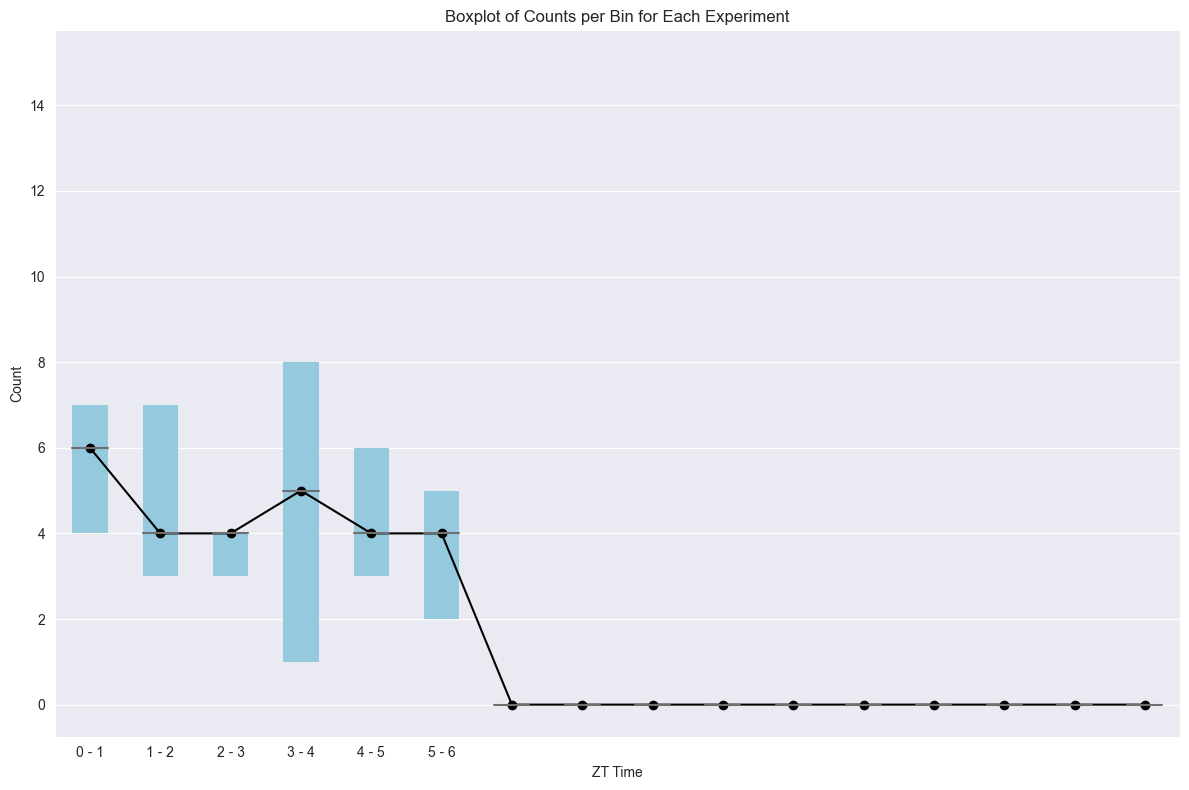

In [47]:
plot_binned_data(grouped_binned,sd=True,sex='F',behavior='Grooming',ylim_val=None)

In [48]:
# Plot Grouped Binned Duration
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

def plot_binned_duration(data_dict,sd=False,sex='F',behavior='Haltere_Switch',ylim_val = None,fig_path = r'C:\Users\Grover\Documents\GitHub\deepsleepfigs\Fig_4_5'):
    target_dict_name = f'SD_{sd}_Sex_{sex}'
    data_df = data_dict[target_dict_name]
    plt.figure(figsize=(12, 8))
    
    sns.boxplot(data=data_df, x='bin', y='duration_sec', showfliers=False, color="skyblue",width=0.5, notch=False, boxprops=dict(edgecolor='none'),showcaps=False, whiskerprops={'visible': False})
    
    # Calculate the median values for each time bin
    medians = data_df.groupby('bin')['duration_sec'].median().reset_index()
    
    # Plot the medians using the mid_points for the x-axis
    plt.plot(range(len(medians)), medians['duration_sec'], color='black', linestyle='-', marker='o', label="Median")

    plt.title("Boxplot of Counts per Bin for Each Experiment")

    if sd:
        xticklabels = [f'{x%24} - {(x+1)%24}' for x in np.arange(0, 6, 1)]
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels)
        plt.xlabel("Time (ZT)")
    else:
        xticklabels = [f'{x%24} - {(x+1)%24}' for x in np.arange(10, 26, 1)]
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels)
        plt.xlabel("Time (ZT)")

    plt.xlabel("ZT Time")
    
    if ylim_val is not None:
        plt.ylim(ylim_val)

    plt.tight_layout()
    # Save the figure to disk
    plt.savefig(os.path.join(fig_path,f'{target_dict_name}_{behavior}_binned_duration.pdf'))
    
    plt.show()
    

[2023-10-28 19:47:27] INFO - maxp pruned
[2023-10-28 19:47:27] INFO - LTSH dropped
[2023-10-28 19:47:27] INFO - cmap pruned
[2023-10-28 19:47:27] INFO - kern dropped
[2023-10-28 19:47:27] INFO - post pruned
[2023-10-28 19:47:27] INFO - PCLT dropped
[2023-10-28 19:47:27] INFO - JSTF dropped
[2023-10-28 19:47:27] INFO - meta dropped
[2023-10-28 19:47:27] INFO - DSIG dropped
[2023-10-28 19:47:27] INFO - GPOS pruned
[2023-10-28 19:47:27] INFO - GSUB pruned
[2023-10-28 19:47:27] INFO - glyf pruned
[2023-10-28 19:47:27] INFO - Added gid0 to subset
[2023-10-28 19:47:27] INFO - Added first four glyphs to subset
[2023-10-28 19:47:27] INFO - Closing glyph list over 'GSUB': 38 glyphs before
[2023-10-28 19:47:27] INFO - Glyph names: ['.notdef', 'B', 'C', 'E', 'T', 'Z', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'glyph00001', 'glyph00002', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'x', 'zero']
[2023-

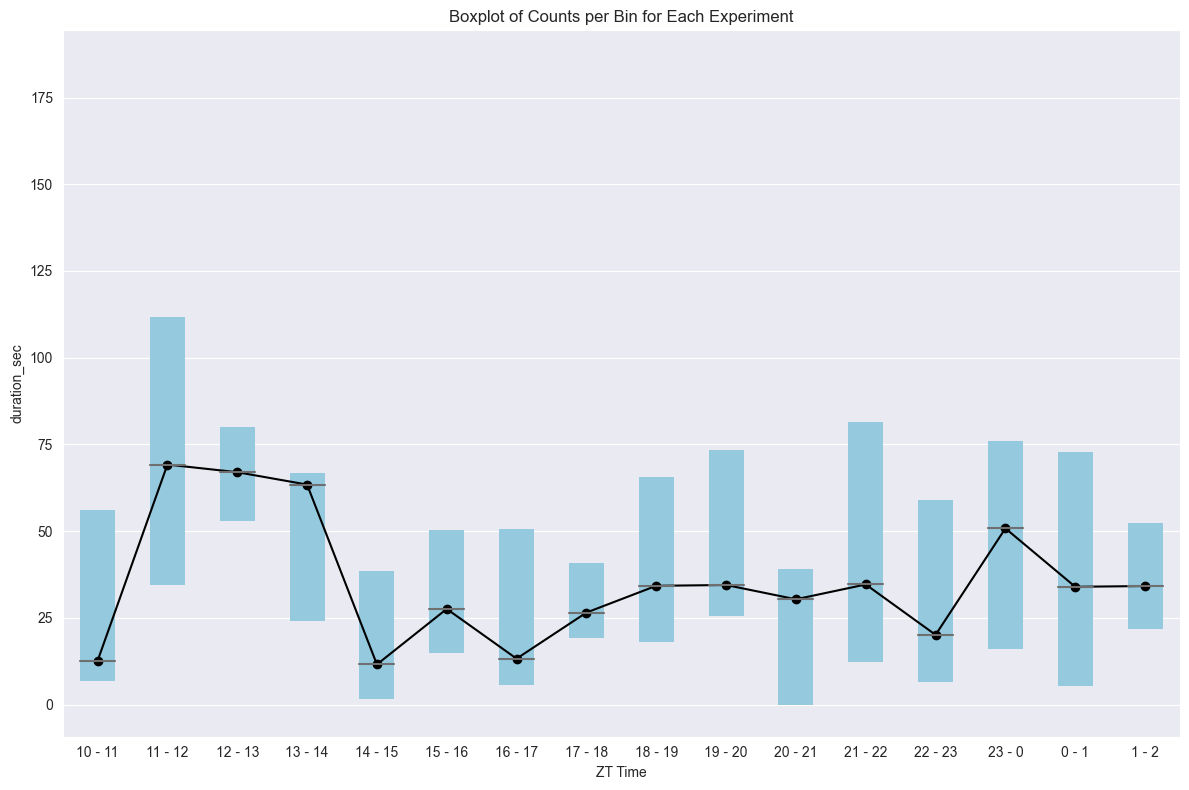

In [52]:
plot_binned_duration(grouped_binned_duration,sd=False,sex='F',behavior='Grooming',ylim_val=None)

In [53]:
# Save the dataframe to disk
import pickle
folder_path = io_process.get_prediction_result_folder('Grooming')


# Save grouped_dict and grouped_binned to disk
with open(os.path.join(folder_path, 'grouped_dict.pkl'), 'wb') as f:
    pickle.dump(grouped_dict, f)
    
with open(os.path.join(folder_path, 'grouped_binned.pkl'), 'wb') as f:
    pickle.dump(grouped_binned, f)

with open(os.path.join(folder_path, 'grouped_binned_duration.pkl'), 'wb') as f:
    pickle.dump(grouped_binned_duration, f)

In [63]:
grouped_binned

{'SD_False_Sex_M':       start_index  stop_index          region  \
 0           74628       74978  Fly05182022_5d   
 1           92206       92912  Fly05182022_5d   
 2          119208      119255  Fly05182022_5d   
 3          138846      138932  Fly05182022_5d   
 4          139120      139398  Fly05182022_5d   
 ...           ...         ...             ...   
 1615      1572471     1573218  Fly06152022_6d   
 1616      1611787     1611866  Fly06152022_6d   
 1617      1638640     1638670  Fly06152022_6d   
 1618      1727262     1727469  Fly06152022_6d   
 1619      1727764     1727814  Fly06152022_6d   
 
                                             pose.prob_x  \
 0     [757.5094191332659, 757.4981182714304, 757.486...   
 1     [178.81439225541223, 179.39754059579639, 180.9...   
 2     [296.25190910696983, 295.94166939457256, 295.6...   
 3     [241.00906139612198, 240.1294700304667, 239.67...   
 4     [249.25850112736225, 247.8819637298584, 246.19...   
 ...                

In [64]:
sd_true_sex_f = grouped_binned['SD_True_Sex_F']
count_per_bin_per_experiment = sd_true_sex_f.groupby(['ExptNames', 'bin']).size().reset_index(name='Count')

In [67]:
summed_duration_per_bin = sd_true_sex_f.groupby(['ExptNames', 'bin'])['duration'].sum().reset_index(name='TotalDuration')


In [68]:
summed_duration_per_bin

,ExptNames,bin,TotalDuration
0,Fly05272022_SD_5d,"(0, 108000]",582
1,Fly05272022_SD_5d,"(108000, 216000]",1022
2,Fly05272022_SD_5d,"(216000, 324000]",1707
3,Fly05272022_SD_5d,"(324000, 432000]",42
4,Fly05272022_SD_5d,"(432000, 540000]",1739
...,...,...,...
203,Fly08032022_6d_SD_B,"(1188000, 1296000]",0
204,Fly08032022_6d_SD_B,"(1296000, 1404000]",0
205,Fly08032022_6d_SD_B,"(1404000, 1512000]",0
206,Fly08032022_6d_SD_B,"(1512000, 1620000]",0


In [72]:
sd_true_sex_f = grouped_binned['SD_True_Sex_F']
summed_duration_per_bin = sd_true_sex_f.groupby(['ExptNames', 'bin'])['duration'].sum().reset_index(name='TotalDuration')
sd=True
if sd:
    #remove bins larger than 30*60*60*6
    summed_duration_per_bin  = summed_duration_per_bin [summed_duration_per_bin ['bin'].apply(lambda x: x.left < 30*60*60*6)]
else:
    #remove bins larger than 30*60*60*16
    summed_duration_per_bin  = summed_duration_per_bin [summed_duration_per_bin ['bin'].apply(lambda x: x.left < 30*60*60*16)]
    

# Group by 'ExptNames' and grab the last two rows
last_two_bins = summed_duration_per_bin .groupby('ExptNames').apply(lambda group: group.head(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"TotalDuration": "sum"}).reset_index()


combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
first_2_hours_sd_true_sex_f = combined_counts

In [73]:
first_2_hours_sd_true_sex_f['TotalDuration_min'] = first_2_hours_sd_true_sex_f['TotalDuration'] / (30 *60)

In [75]:
sd_false_sex_f = grouped_binned['SD_False_Sex_F']
summed_duration_per_bin = sd_false_sex_f.groupby(['ExptNames', 'bin'])['duration'].sum().reset_index(name='TotalDuration')
sd=False
if sd:
    #remove bins larger than 30*60*60*6
    summed_duration_per_bin = summed_duration_per_bin[summed_duration_per_bin['bin'].apply(lambda x: x.left < 30*60*60*6)]
    

# Group by 'ExptNames' and grab the last two rows
last_two_bins = summed_duration_per_bin.groupby('ExptNames').apply(lambda group: group.tail(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"TotalDuration": "sum"}).reset_index()

combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
last_2_hours_sd_false_sex_f= combined_counts

In [76]:
last_2_hours_sd_false_sex_f['TotalDuration_min'] = last_2_hours_sd_false_sex_f['TotalDuration'] / (30 *60)

[2023-10-30 00:59:29] INFO - maxp pruned
[2023-10-30 00:59:29] INFO - LTSH dropped
[2023-10-30 00:59:29] INFO - cmap pruned
[2023-10-30 00:59:29] INFO - kern dropped
[2023-10-30 00:59:29] INFO - post pruned
[2023-10-30 00:59:29] INFO - PCLT dropped
[2023-10-30 00:59:29] INFO - JSTF dropped
[2023-10-30 00:59:29] INFO - meta dropped
[2023-10-30 00:59:29] INFO - DSIG dropped
[2023-10-30 00:59:29] INFO - GPOS pruned
[2023-10-30 00:59:29] INFO - GSUB pruned
[2023-10-30 00:59:29] INFO - glyf pruned
[2023-10-30 00:59:29] INFO - Added gid0 to subset
[2023-10-30 00:59:29] INFO - Added first four glyphs to subset
[2023-10-30 00:59:29] INFO - Closing glyph list over 'GSUB': 32 glyphs before
[2023-10-30 00:59:29] INFO - Glyph names: ['.notdef', 'C', 'D', 'F', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'four', 'glyph00001', 'glyph00002', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'w', 'zero']
[2023-10-30 00:59:29] INFO - Glyph IDs:   [0, 1, 2, 3, 19

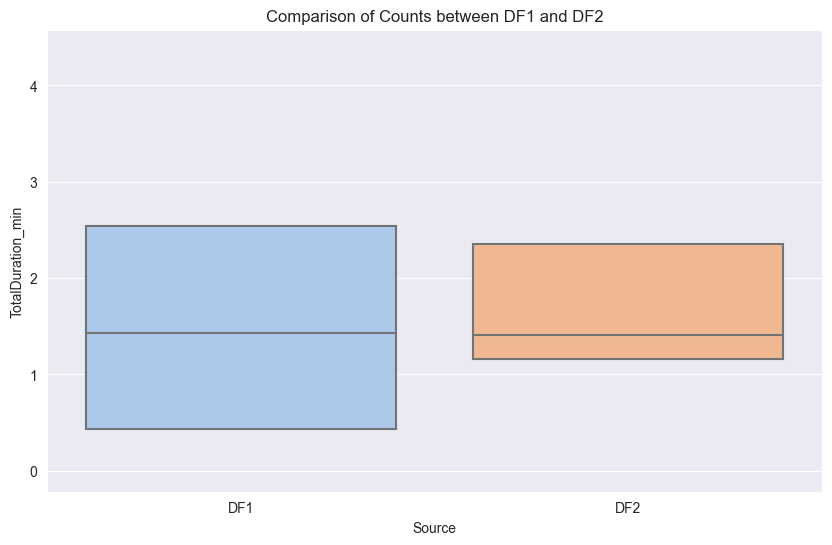

In [79]:

import pandas as pd

last_2_hours_sd_false_sex_f['Source'] = 'DF1'
first_2_hours_sd_true_sex_f['Source'] = 'DF2'

combined_df = pd.concat([last_2_hours_sd_false_sex_f, first_2_hours_sd_true_sex_f], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Source', y='TotalDuration_min', palette="pastel", showfliers=False,showcaps=False, whiskerprops={'visible': False})
plt.title('Comparison of Counts between DF1 and DF2')
# Save the figure
plt.savefig('boxplot_comparison_grooming_last_two_hours_female.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [91]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(last_2_hours_sd_false_sex_f['TotalDuration_min'], first_2_hours_sd_true_sex_f['TotalDuration_min'])
print(f"Statistic: {statistic}, P-value: {p_value}")






Statistic: 58.0, P-value: 0.6868651803414656


In [81]:
sd_true_sex_m = grouped_binned['SD_True_Sex_M']
summed_duration_per_bin = sd_true_sex_m.groupby(['ExptNames', 'bin'])['duration'].sum().reset_index(name='TotalDuration')
sd=True
if sd:
    #remove bins larger than 30*60*60*6
    summed_duration_per_bin  = summed_duration_per_bin [summed_duration_per_bin ['bin'].apply(lambda x: x.left < 30*60*60*6)]
else:
    #remove bins larger than 30*60*60*16
    summed_duration_per_bin  = summed_duration_per_bin [summed_duration_per_bin ['bin'].apply(lambda x: x.left < 30*60*60*16)]
    

# Group by 'ExptNames' and grab the last two rows
last_two_bins = summed_duration_per_bin .groupby('ExptNames').apply(lambda group: group.head(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"TotalDuration": "sum"}).reset_index()


combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
first_2_hours_sd_true_sex_m = combined_counts

In [82]:
first_2_hours_sd_true_sex_m['TotalDuration_min'] = first_2_hours_sd_true_sex_m['TotalDuration'] / (30 *60)

In [83]:
sd_false_sex_m = grouped_binned['SD_False_Sex_M']
summed_duration_per_bin = sd_false_sex_m.groupby(['ExptNames', 'bin'])['duration'].sum().reset_index(name='TotalDuration')
sd=False
if sd:
    #remove bins larger than 30*60*60*6
    summed_duration_per_bin = summed_duration_per_bin[summed_duration_per_bin['bin'].apply(lambda x: x.left < 30*60*60*6)]
    

# Group by 'ExptNames' and grab the last two rows
last_two_bins = summed_duration_per_bin.groupby('ExptNames').apply(lambda group: group.tail(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"TotalDuration": "sum"}).reset_index()

combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
last_2_hours_sd_false_sex_m= combined_counts

In [84]:
last_2_hours_sd_false_sex_m['TotalDuration_min'] = last_2_hours_sd_false_sex_m['TotalDuration'] / (30 *60)

[2023-10-30 01:03:17] INFO - maxp pruned
[2023-10-30 01:03:17] INFO - LTSH dropped
[2023-10-30 01:03:17] INFO - cmap pruned
[2023-10-30 01:03:17] INFO - kern dropped
[2023-10-30 01:03:17] INFO - post pruned
[2023-10-30 01:03:17] INFO - PCLT dropped
[2023-10-30 01:03:17] INFO - JSTF dropped
[2023-10-30 01:03:17] INFO - meta dropped
[2023-10-30 01:03:17] INFO - DSIG dropped
[2023-10-30 01:03:17] INFO - GPOS pruned
[2023-10-30 01:03:17] INFO - GSUB pruned
[2023-10-30 01:03:17] INFO - glyf pruned
[2023-10-30 01:03:17] INFO - Added gid0 to subset
[2023-10-30 01:03:17] INFO - Added first four glyphs to subset
[2023-10-30 01:03:17] INFO - Closing glyph list over 'GSUB': 32 glyphs before
[2023-10-30 01:03:17] INFO - Glyph names: ['.notdef', 'C', 'D', 'F', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'four', 'glyph00001', 'glyph00002', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'w', 'zero']
[2023-10-30 01:03:17] INFO - Glyph IDs:   [0, 1, 2, 3, 19

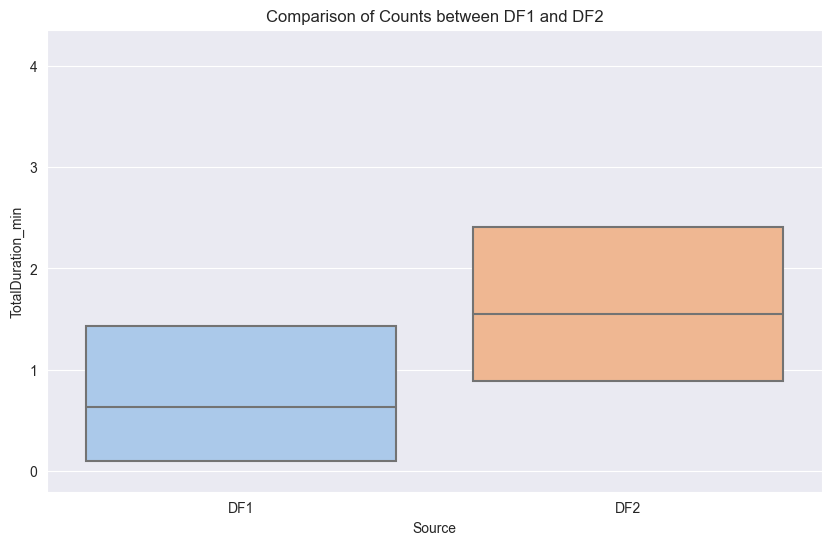

In [86]:
import pandas as pd

last_2_hours_sd_false_sex_m['Source'] = 'DF1'
first_2_hours_sd_true_sex_m['Source'] = 'DF2'

combined_df = pd.concat([last_2_hours_sd_false_sex_m, first_2_hours_sd_true_sex_m], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Source', y='TotalDuration_min', palette="pastel", showfliers=False,showcaps=False, whiskerprops={'visible': False})
plt.title('Comparison of Counts between DF1 and DF2')
# Save the figure
plt.savefig('boxplot_comparison_grooming_last_two_hours_male.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [90]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(last_2_hours_sd_false_sex_m['TotalDuration_min'], first_2_hours_sd_true_sex_m['TotalDuration_min'])
print(f"Statistic: {statistic}, P-value: {p_value}")





Statistic: 87.0, P-value: 0.0111518489354603


In [98]:
grouped_dict['SD_False_Sex_F']['Fly05202022_5d'].columns

Index(['start_index', 'stop_index', 'region', 'pose.prob_x', 'pose.prob_y',
       'pose.halt_x', 'pose.halt_y', 'pose.thor_post_x', 'pose.thor_post_y',
       'distance.origin-halt', 'distance.origin-prob',
       'distance.origin-thor_post', 'distance.head-prob',
       'distance.thor_post-halt',
       'distance.avg(thor_post-joint1,thor_post-joint2,thor_post-joint3)',
       'distance.avg(origin-joint1,origin-joint2,origin-joint3)',
       'start_index_hr', 'stop_index_hr'],
      dtype='object')